In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf


from IPython import display
%matplotlib inline


from sklearn.metrics import log_loss, accuracy_score, f1_score, classification_report, roc_auc_score, auc

from sklearn.model_selection import KFold, train_test_split

from tqdm import tqdm_notebook

## Investigation

In [2]:
data = pd.read_csv("../data/train.csv")
data.y.value_counts()

1.0    790
0.0    315
Name: y, dtype: int64

Значит имеем задачу классификации, классы не сбалансированы. <br/>
В качестве метрики подойдет roc_auc или f1_score, они чувствительны к ошибкам в обоих классах, будем использовать f1_score. 
  
Хотим сравнить модели отбора признаков, кандидаты следующие, глобально это либо линейные модели с улучшениями для отбора признаков, либо деревья:
- линейные модели с elastic net или lasso прибавками к ошибке
- DFS (сетка из статьи)

- Случайный лес
- AdaBoost (на деревьях)
- Градиентный бустинг (тоже на деревьях)
- LightGBM

Зафиксируем сначала просто трейн\тест разбиение, сохранив баланс классов, потом можно будет погонять кросс-валидацию на 3-5 фолдов.

In [3]:
np.random.seed(239)

In [4]:
X = data[data.columns[:-1]].values
y = data.y.values

In [5]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y)

In [6]:
## Check ballance
print("train: ", y_tr.sum()/y_tr.shape[0])
print("test: ", y_te.sum()/y_te.shape[0])
print("all: " , y.sum()/y.shape[0])

train:  0.714975845410628
test:  0.7148014440433214
all:  0.7149321266968326


Общий подход будет следующий:
- Учим несколько моделей с разными параметрами на трейн сете
- Вытаскиваем feature importances
- Смотрим насколько параметры модели влияют на ранжирование фичей
- Учим модели с разным количеством фичей, добавляя жадно от самой важной (это не обязательно лучшая стратегия, но быстрая)
- Выбираем лучший набор фичей с точки зрения f1_score
- Возможно подтюниваем параметры модели


- Пробуем кросс валидацию на несколько фолдов

## Tree based models

#### Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
rf = RandomForestClassifier(100)
rf.fit(X_tr, y_tr)
rf_pred = rf.predict_proba(X_te)

In [53]:
print(roc_auc_score(y_te, rf_pred[:,1]))
print(classification_report(y_te, rf_pred[:,1] > 0.5))

0.9447001662191535
             precision    recall  f1-score   support

        0.0       0.86      0.68      0.76        79
        1.0       0.88      0.95      0.92       198

avg / total       0.88      0.88      0.87       277



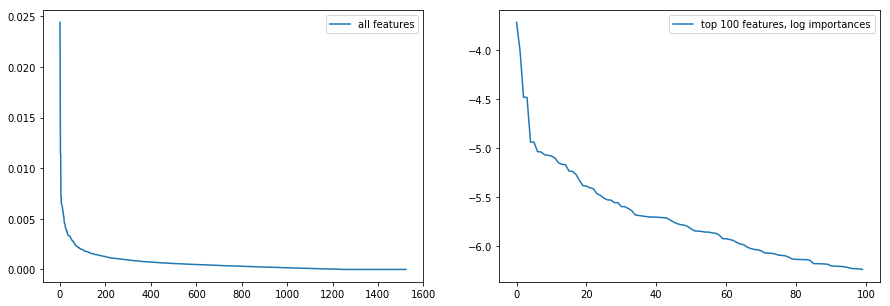

In [54]:
f, (a1, a2) = plt.subplots(1,2,figsize=(15,5))
a1.plot(sorted(rf.feature_importances_)[::-1][:], label = 'all features')
a2.plot(np.log(sorted(rf.feature_importances_)[::-1][:100]), label = 'top 100 features, log importances')
a1.legend()
a2.legend()
plt.show()

Какого-то явного скачка не видно в графиках важности фичей.

In [39]:
def verify_model(model, X_tr, y_tr, X_te, y_te, feature_importances, metric, feature_range, step):
    sorted_importances_args_r = np.argsort(feature_importances)[::-1]
    
    scores = np.zeros((2, (feature_range[1] - feature_range[0]) // step))
    for i, top_features in tqdm_notebook(enumerate(range(feature_range[0], feature_range[1], step))):
        mask = np.zeros(X.shape[1]).astype(bool)
        mask[sorted_importances_args_r[:top_features]] = True
        
        model.fit(X_tr[:,mask], y_tr)
        pred_proba = model.predict_proba(X_te[:,mask])[:,1]
        
        scores[0, i] = top_features
        scores[1, i] = metric(y_te, pred_proba)
        #print(top_features, metric(y_te, pred_proba))
        #print(classification_report(y_te, rf_pred[:,1] > 0.5))
    return scores

In [55]:
rf_test = RandomForestClassifier(100)
rf_scores = verify_model(rf_test, X_tr, y_tr, X_te, y_te, rf.feature_importances_, roc_auc_score, [1,60], 1)

A Jupyter Widget

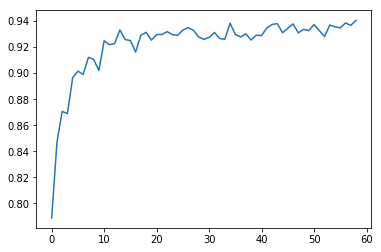

In [56]:
plt.plot(rf_scores[1])

На глаз логичный порог в районе 15 фичей, хотя результат с 60-ю лучше. Для деревьев это нормально, даже незначительные фичи, могут дать небольшой прирост качества

In [57]:
np.save("../storage/rf_feature_importances", rf.feature_importances_)

#### Gradient Boosting

In [45]:
from sklearn.ensemble import GradientBoostingClassifier

In [60]:
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, verbose=1)
gb.fit(X_tr, y_tr)
gb_pred = gb.predict_proba(X_te)

      Iter       Train Loss   Remaining Time 
         1           1.0779           12.37s
         2           0.9887           12.45s
         3           0.9160           12.37s
         4           0.8558           12.28s
         5           0.8063           12.21s
         6           0.7614           12.16s
         7           0.7225           12.03s
         8           0.6885           12.07s
         9           0.6541           11.98s
        10           0.6258           11.82s
        20           0.4434           10.61s
        30           0.3455            9.14s
        40           0.2978            7.69s
        50           0.2626            6.33s
        60           0.2406            5.01s
        70           0.2172            3.75s
        80           0.1963            2.50s
        90           0.1768            1.25s
       100           0.1604            0.00s


In [61]:
print(roc_auc_score(y_te, gb_pred[:,1]))
print(classification_report(y_te, gb_pred[:,1] > 0.5))

0.92692750287687
             precision    recall  f1-score   support

        0.0       0.79      0.76      0.77        79
        1.0       0.91      0.92      0.91       198

avg / total       0.87      0.87      0.87       277



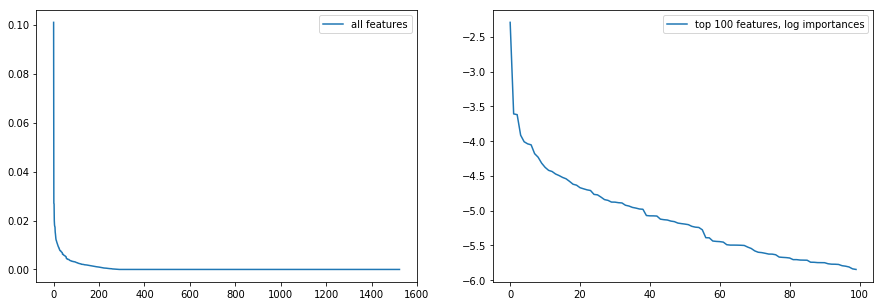

In [66]:
f, (a1, a2) = plt.subplots(1,2,figsize=(15,5))
a1.plot(sorted(gb.feature_importances_)[::-1][:], label = 'all features')
a2.plot(np.log(sorted(gb.feature_importances_)[::-1][:100]), label = 'top 100 features, log importances')
a1.legend()
a2.legend()
plt.show()

In [67]:
gb_test = GradientBoostingClassifier()
gb_scores = verify_model(gb_test, X_tr, y_tr, X_te, y_te, gb.feature_importances_, roc_auc_score, [1,60], 1)

A Jupyter Widget

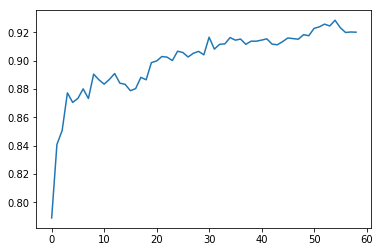

In [68]:
plt.plot(gb_scores[1])

Что интересно фичи выбранные random forest и gradient boosting очень отличаются. Наверное бустинг можно потюнить (уменьшить глубину деервьев, покрутить learning rate), но пока просто остановимся на RF, т.к. у него и auc лучше, и фичи гораздо более четко фильтруются.

## Linear Models

В отличие от статьи, у нас классификация бинарная, значит нет причин не использовать стандартные модели с l1 регуляризацией.

С линейными моделями все немного не так как с деревьями, l1 регуляризации дадут нам разряженый вектор весов, так что у нас не будет возможности сортировать по feature importance(???). Количество фичей будет отбираться за счет веса регуляризации.



В данных наверняка есть скореллированные столбцы, для лассо это не должно быть критично
https://arxiv.org/pdf/1204.1605.pdf


Преред тем как что-то делать, стандартизируем данные, чтобы среднее было 0, а величина в диапазоне от -1 до 1. (для деревьев это было не важно)

In [232]:
class_weights = {0.: (y_tr == 0).sum() / y_tr.shape[0], 1.: (y_tr == 1).sum() / y_tr.shape[0]}

In [233]:
def standartize(X):
    div = np.abs((X - X.mean(0))).max(0)
    div[div == 0] = 1
    return (X - X.mean(0)) / div

In [234]:
X_tr_s, X_te_s = standartize(X_tr), standartize(X_te)

#### Lasso

In [71]:
from sklearn.linear_model import LogisticRegression

Попробуем поискать параметр регуляризации

In [122]:
def check_lasso(C, X_tr, y_tr, X_te, y_te, c_w):
    lr_lasso = LogisticRegression('l1', C = C, class_weight=c_w)
    lr_lasso.fit(X_tr, y_tr)
    lasso_pred = lr_lasso.predict_proba(X_te)
    return roc_auc_score(y_te, lasso_pred[:,1]), (lr_lasso.coef_ != 0).sum(), lr_lasso

In [240]:
good_C_logspace = np.logspace(-2, 1, n, base=10)
print(good_C_logspace)

[ 0.01        0.02154435  0.04641589  0.1         0.21544347  0.46415888
  1.          2.15443469  4.64158883 10.        ]


In [241]:
n = 10
lasso_scores_vs_nonzeros = np.zeros((3,n))
lasso_models = []

for i, C in tqdm_notebook(enumerate(good_C_logspace)):
    res = check_lasso(C, X_tr_s, y_tr, X_te_s, y_te, class_weights)
    lasso_scores_vs_nonzeros[1:, i] = res[:-1]
    lasso_scores_vs_nonzeros[0, i] = C
    
    lasso_models.append(res[-1])

A Jupyter Widget

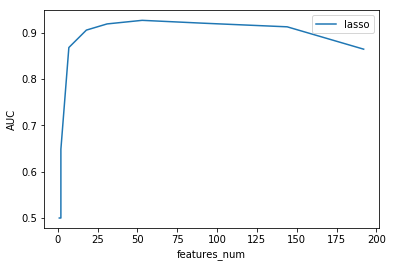

In [242]:
plt.plot(lasso_scores_vs_nonzeros[2], lasso_scores_vs_nonzeros[1], label = 'lasso')
plt.xlabel("features_num")
plt.ylabel("AUC")
plt.legend()

Lasso рекоммендует что-то в районе 20 - 50 фичей, посмотрим какой регуляризации это соответсвует, и поищем в том регионе еще полуше (да, придется копировать код, потому что я спешу)

In [248]:
lasso_scores_vs_nonzeros

array([[1.00000000e-02, 2.15443469e-02, 4.64158883e-02, 1.00000000e-01,
        2.15443469e-01, 4.64158883e-01, 1.00000000e+00, 2.15443469e+00,
        4.64158883e+00, 1.00000000e+01],
       [5.00000000e-01, 5.00000000e-01, 6.48478455e-01, 8.68431147e-01,
        9.06086178e-01, 9.19447641e-01, 9.27183225e-01, 9.21045902e-01,
        9.13182457e-01, 8.64851042e-01],
       [1.00000000e+00, 2.00000000e+00, 2.00000000e+00, 7.00000000e+00,
        1.80000000e+01, 3.10000000e+01, 5.30000000e+01, 9.10000000e+01,
        1.44000000e+02, 1.92000000e+02]])

In [254]:
good_C_logspace_2 = np.logspace(-1, 0.5, n, base=10)
print(good_C_logspace_2)

[0.1        0.14677993 0.21544347 0.31622777 0.46415888 0.68129207
 1.         1.46779927 2.15443469 3.16227766]


In [255]:
n = 10
lasso_scores_vs_nonzeros_2 = np.zeros((3,n))
lasso_models_2 = []

for i, C in tqdm_notebook(enumerate(good_C_logspace_2)):
    res = check_lasso(C, X_tr_s, y_tr, X_te_s, y_te, class_weights)
    lasso_scores_vs_nonzeros_2[1:, i] = res[:-1]
    lasso_scores_vs_nonzeros_2[0, i] = C
    
    lasso_models_2.append(res[-1])

A Jupyter Widget

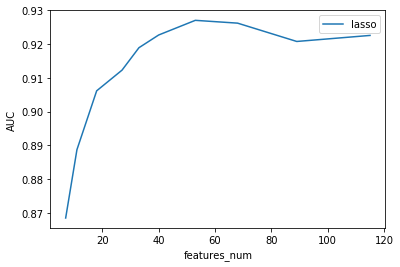

In [256]:
plt.plot(lasso_scores_vs_nonzeros_2[2], lasso_scores_vs_nonzeros_2[1], label = 'lasso')
plt.xlabel("features_num")
plt.ylabel("AUC")
plt.legend()

Прямо хорошо модели становится, когда мы сохраняем около 55 фичей, посмотрим что за фичи и сколько их

In [258]:
model_num = lasso_scores_vs_nonzeros_2[1].argmax()

In [261]:
lasso_best_model = lasso_models_2[model_num]
np.save("../storage/lasso_feature_importance", lasso_best_model.coef_[0])

In [264]:
print('Selected : ', np.where(lasso_best_model.coef_[0] != 0)[0]) 

Selected :  [  47   79   83   87  367  376  381  456  457  458  463  472  478  491
  542  545  557  569  575  609  649  662  666  672  702  789  795  799
  803  805  806  807  879  881  982  990 1013 1025 1053 1082 1088 1191
 1214 1296 1332 1350 1387 1394 1395 1424 1426 1460 1523]


Это похоже на то что выбрал лес. Но анализ потом

## Elastic Net && DFS

Обе модели подразумевают SGD для решения, используют похожую регурялизацю, так что можно сделать две похожих tf модельки для DFS и Elastic Net. 

Работать будем с Elastic Net лог регрессией и с DFS сразу многослойной.

In [265]:
from keras.layers import Dense

Using TensorFlow backend.


In [273]:
class WeightLayer:
    '''Weight layer, simply performs elementwise multiplication between input and weights'''
    def __init__(self, shape, name, w=None):
        self.shape = shape
        self.name = name
        
        with tf.variable_scope(name) as scope:
            if w is None:
                self.w = tf.get_variable('w', shape=shape, initializer=None, trainable=True)
            else:
                self.w = w
        self.scope = scope
        
    def __call__(self, inp):
        with tf.variable_scope(self.scope):
            with tf.name_scope(self.scope.original_name_scope):
                out = self.w * inp
                return out                

In [305]:
class ElasticNet:
    '''
    Class for ElasticNet model.
    Also responsible for creating loss terms
    '''
    def __init__(self, name, input_shape):
        self.name = name
        self.input_shape = input_shape
        
        with tf.variable_scope(name) as scope:
            self.dense = Dense(1, activation=None)
        self.scope = scope
    
    def __call__(self, inp):
        with tf.variable_scope(self.scope):
            with tf.name_scope(self.scope.original_name_scope):                
                logits = self.dense(inp)
                out = tf.nn.sigmoid(logits)
        return logits, out
        
    def get_regularization_term(self, alpha):
        with tf.variable_scope("regularization"):
            return  (1-alpha) * tf.reduce_sum(tf.abs(self.dense.weights[0])) +\
                        alpha * tf.reduce_sum(tf.square(self.dense.weights[0]))


In [306]:
class DFS:
    '''
    Class for DFS model.
    Also responsible for creating loss terms
    '''
    def __init__(self, name, input_shape, dense_sizes=[256, 256]):
        self.name = name
        self.input_shape = input_shape
        
        with tf.variable_scope(name) as scope:
            self.weight_layer = WeightLayer(input_shape, 'wl')
            self.dense_array = [Dense(x, activation=tf.nn.relu) for x in dense_sizes] + [Dense(2, activation=None)]
        self.scope = scope
    
    def __call__(self, inp):
        with tf.variable_scope(self.scope):
            with tf.name_scope(self.scope.original_name_scope):
                weight_layer_out = self.weight_layer(inp)
                next_var = weight_layer_out
                for layer in self.dense_array:
                    next_var = layer(next_var)
                
                logits = next_var
                out = tf.nn.softmax(logits)
        return logits, out

    def get_weighted_layer_regularization_term(self, alpha):
        with tf.variable_scope("weighted_layer_regularization"):
            return (1-alpha) * tf.reduce_sum(tf.abs(self.weight_layer.w)) +\
                    alpha * tf.reduce_sum(tf.square(self.weight_layer.w))
        
    def get_dense_layers_regularization_term(self, alpha):
        with tf.variable_scope("dense_layers_regularization"):
            r_term = 0
            for layer in self.dense_array:
                r_term += (1-alpha) * tf.reduce_sum(tf.abs(layer.weights[0])) +\
                            alpha * tf.reduce_sum(tf.square(layer.weights[0]))

            return r_term

In [413]:
class experiment:
    '''Performs experiment with either ElasticNet or DFS, stores parametres of the experiment'''
    def __init__(self,
                 name,
                 feature_mask,
                 session,
                 model_type='dfs',
                 lambda_1=0.001,
                 lambda_2=0.5,
                 alpha_1=0.00002,
                 alpha_2=0.5,
                 dense_sizes = [256, 256]):
        self.name = name
        self.session = session
        self.feature_mask = feature_mask
        self.n_features = self.feature_mask.sum()
        if not model_type in ['elastic', 'dfs']:
            raise ValueError("model can be either 'dfs' or 'elastic'")
        self.model_type = model_type
        
        self.alpha_1 = alpha_1
        self.alpha_2 = alpha_2
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        
        self.dense_sizes = dense_sizes
        
        self.ready = False
        
    def _initialize_network(self):
        with tf.variable_scope(self.name) as net_scope:
            ## Initialize network
            self.inp = tf.placeholder(tf.float32, [None, self.n_features])
            if self.model_type == 'dfs':
                self.model = DFS("DFS", self.n_features, self.dense_sizes)
            elif self.model_type == 'elastic':
                self.model = ElasticNet("ElasticNet", self.n_features)                
     
            self.logits, self.out = self.model(self.inp)

            ##Prepare target and loss weights
            self.target = tf.placeholder(tf.float32, [None])
            self.loss_weights = tf.placeholder(tf.float32, [None])

            
            if self.model_type == 'dfs':
                ##Loss terms
                self.ce_loss = tf.losses.softmax_cross_entropy(tf.one_hot(tf.cast(self.target, tf.int32), 2),
                                                               self.logits,
                                                               weights=self.loss_weights)
                self.features_weights_regularization = \
                    self.lambda_1 * self.model.get_weighted_layer_regularization_term(self.lambda_2) 
                self.network_weights_regularization = \
                    self.alpha_1 * self.model.get_dense_layers_regularization_term(self.alpha_2)

                self.loss = self.ce_loss + self.features_weights_regularization + self.network_weights_regularization
            elif self.model_type == 'elastic':
                self.ce_loss = tf.losses.log_loss(self.target, tf.reshape(self.out, [-1]), self.loss_weights)
                
                self.weights_regularization = \
                    self.lambda_1 * self.model.get_regularization_term(self.lambda_2)

                self.loss = self.ce_loss + self.weights_regularization

            ## Optimizer, Adam optimizes everything
            self.optimizer = tf.train.AdamOptimizer()
            self.train_step = self.optimizer.minimize(self.loss, var_list=tf.trainable_variables(self.name))

        ## Initialize only this experiment    
        self.uninitialized_vars = []
        for var in tf.all_variables():
            try:
                sess.run(var)
            except tf.errors.FailedPreconditionError:
                self.uninitialized_vars.append(var)

        init_new_vars_op = tf.initialize_variables(self.uninitialized_vars)
        sess.run(init_new_vars_op)
        
        self.net_scope = net_scope
            
    def _plot_graphs(self, plot_start):
        f, (a1, a2) = plt.subplots(2,1,figsize = (10,10))
        display.clear_output(wait=True)
        a1.plot(self.train_ce_losses[plot_start:], label='train ce')
        a1.plot(self.val_ce_losses[plot_start:], label = 'val ce')

        a2.plot(self.val_auc_scores[:], label='val_auc')

        a1.legend()
        a2.legend()
        plt.show()
             
        
    def run_experiment(self, X_tr, y_tr, X_te, y_te, max_epochs, b_s=40, plot=True, warm_up=40, early_stop=20, plot_start=0):
        if not self.ready:
            self._initialize_network()
            self.ready = True

            self.class_weights = {0.: (y_tr == 0).sum() / y_tr.shape[0], 1.: (y_tr == 1).sum() / y_tr.shape[0]}
            self.val_weights = np.array([self.class_weights[y] for y in y_te])

            self.train_ce_losses = []
            self.val_ce_losses = []
            self.val_auc_scores = []

        for epoch in range(max_epochs):
            train_ce_loss = 0

            for i, (batch_X, batch_y) in enumerate(iterate_minibatches(X_tr, y_tr, b_s)):
                batch_weights = np.array([self.class_weights[y] for y in batch_y])

                batch_loss = self.session.run([self.train_step, self.ce_loss],
                                      feed_dict={self.inp : batch_X[:,self.feature_mask],
                                                 self.target: batch_y,
                                                 self.loss_weights:batch_weights})

                train_ce_loss += batch_loss[1] * batch_X.shape[0]


            val_ce_loss = self.session.run(self.ce_loss,  feed_dict={self.inp : X_te[:,self.feature_mask],
                                                             self.target: y_te,
                                                             self.loss_weights : self.val_weights})
            
            val_pred = self.session.run(self.out, feed_dict={self.inp : X_te[:,self.feature_mask]})
            if self.model_type == 'dfs': val_pred = val_pred[:, 1]
            val_auc_score = roc_auc_score(y_te, val_pred) 

            self.val_ce_losses.append(val_ce_loss)
            self.val_auc_scores.append(val_auc_score)
            self.train_ce_losses.append(train_ce_loss / X_tr.shape[0])


            if plot:
                self._plot_graphs(plot_start)


            if epoch > warm_up:
                if np.argmax(np.array(self.val_auc_scores[-early_stop:])) == 0:
                    print("early stop")
                    break

def iterate_minibatches(x, y, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(y.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, y.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield x[excerpt], y[excerpt]

#### DFS 

Надо подобрать веса регуляризации.
После попробуем запустить с несколькими разными архитектурами такую сетку и посмотрим что получится на слое отбора фичей. 
Остановка обучения либо по макс кол-ву эпох, либо если за 20 эпох не смогли улучшить val_auc. Еще хорошо бы сохранять веса с лучшей эпохи, но для начала будем считать, что модель не успевает испортиться (графики обучения вполне неплохо свидетельствуют об этом)

In [445]:
tf.reset_default_graph()
sess = tf.Session()

In [415]:
exp_1 = experiment("DFS_visual", np.ones(X.shape[1]).astype(bool), sess)

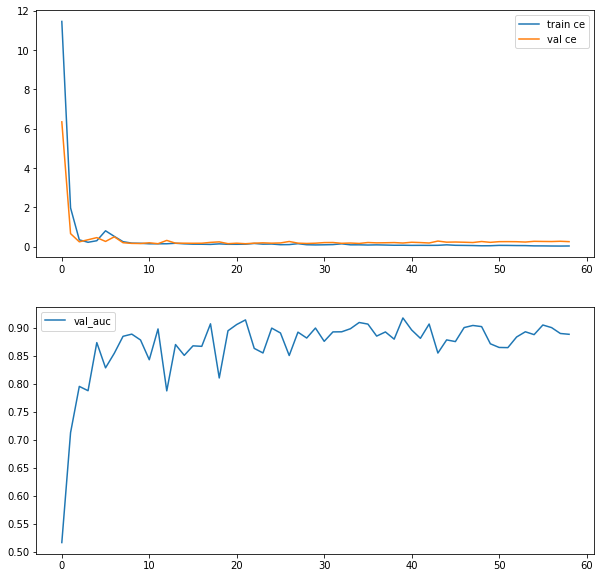

early stop


In [416]:
exp_1.run_experiment(X_tr, y_tr, X_te, y_te, 200)

In [427]:
print("best score :", max(exp_1.val_auc_scores))

best score : 0.9174018667689554


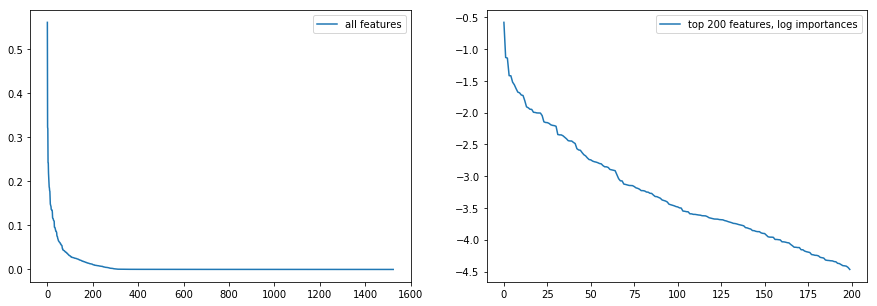

In [422]:
f, (a1, a2) = plt.subplots(1,2,figsize=(15,5))
a1.plot(sorted(np.abs(sess.run(exp_1.model.weight_layer.w)))[::-1][:], label = 'all features')
a2.plot(np.log(sorted(np.abs(sess.run(exp_1.model.weight_layer.w)))[::-1][:200]), label = 'top 200 features, log importances')
a1.legend()
a2.legend()
plt.show()

Можно попробовать поподбирать $\lambda_1$ и $\alpha_1$ (веса регуляризации), но шибко не разгуляешься, это сетки, все медленно. Попробуем поискать вокруг параметров, которые я получил, пока эксперементировал с кодом                  $\lambda_1=0.001, \alpha_1=0.00002$. 

В целом это только модель ранжирующая признаки, а не финальный самый крутой вариант на отобранных. 

In [446]:
lambda_1_range = [0.0005, 0.001, 0.002, 0.004]
alpha_1_range = [0.00004, 0.00008, 0.00016,]

In [447]:
grid_search_results = np.zeros((3, len(lambda_1_range) * len(alpha_1_range)))
exps = []
ind = 0

for lambda_1 in lambda_1_range:
    for alpha_1 in alpha_1_range:
        exp = experiment("DFS_" + str(lambda_1) + "_" + str(alpha_1), np.ones(X.shape[1]).astype(bool), sess)
        exp.run_experiment(X_tr, y_tr, X_te, y_te, 200, plot = False)
        
        grid_search_results[0, ind] = lambda_1
        grid_search_results[1, ind] = alpha_1
        grid_search_results[2, ind] = max(exp.val_auc_scores)
        print("exp_results :", lambda_1, alpha_1, max(exp.val_auc_scores))
        
        exps.append(exp)
        
        ind += 1

early stop
exp_results : 0.0005 4e-05 0.9292929292929293
early stop
exp_results : 0.0005 8e-05 0.8981588032220944
early stop
exp_results : 0.0005 0.00016 0.9049993606955632
early stop
exp_results : 0.001 4e-05 0.9146528576908324
early stop
exp_results : 0.001 8e-05 0.9048075693645314
early stop
exp_results : 0.001 0.00016 0.9246899373481652
early stop
exp_results : 0.002 4e-05 0.9220687891573968
early stop
exp_results : 0.002 8e-05 0.9071090653369135
early stop
exp_results : 0.002 0.00016 0.9222605804884286
early stop
exp_results : 0.004 4e-05 0.9050632911392406
early stop
exp_results : 0.004 8e-05 0.9178493798746963
early stop
exp_results : 0.004 0.00016 0.9123513617184503


Если посмотреть сколько фичей пересекается для таких отдельных запусков, можно увидеть что их очень мало. Это не очень подходящая нестабильность, которая для сетки понятна. Отранжируем фичи по всем 12-ти экспериментам. Рангом фичи будет такая сумма: $ \sum_{for\ k\ in\ all\ experiments} {{1} \over {(pos_k + 1)} }$

In [486]:
DFS_selected_features = {}

In [487]:
for exp in exps:
    exp_best_features = np.argsort(sess.run(exp.model.weight_layer.w))[::-1][:300]
    for i, feature in enumerate(exp_best_features):
        if feature in DFS_selected_features.keys():
            DFS_selected_features[feature] += 1 / (i + 1)
        else:
            DFS_selected_features[feature] = 1 / (i + 1)

In [488]:
DFS_features_array = np.zeros((2, len(DFS_selected_features)))
for i, (k, v) in enumerate(DFS_selected_features.items()):
    DFS_features_array[0, i] = k
    DFS_features_array[1, i] = v

Построим результаты для стабильно ранжированных фичей, и вытащим наконец в отдельную функцию постройку графиков

In [497]:
def plot_rank(ranks):
    f, (a1, a2) = plt.subplots(1,2,figsize=(15,5))
    a1.plot(sorted(np.abs(ranks))[::-1][:], label = 'all features')
    a2.plot(np.log(sorted(np.abs(ranks)))[::-1][:200], label = 'top 200 features, log importances')
    a1.legend()
    a2.legend()
    plt.show()

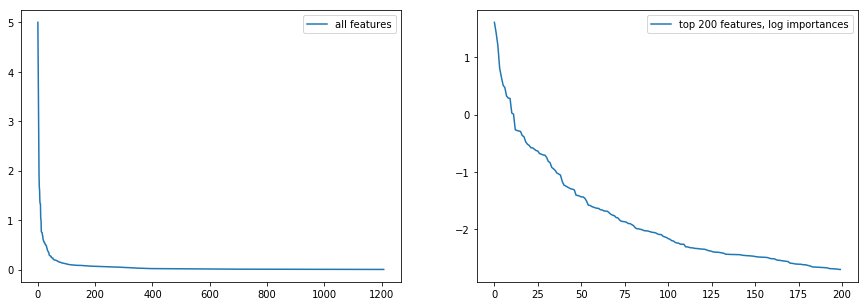

In [498]:
plot_rank(DFS_features_array[1])

Попробуем модели от 10 до 200 фичей с каким-нибудь адекватным шагом. Лосс weighted layer отключаем

In [499]:
DFS_features_array[1]

array([5.00000000e+00, 4.15882353e+00, 7.50534188e-01, ...,
       3.52112676e-03, 3.49650350e-03, 3.48432056e-03])

In [ ]:
for features in range(10, 200, 15):
    

In [418]:
gr = tf.get_default_graph()

writer = tf.summary.FileWriter("../tf_logs", gr)